### Código + **Relatório**

**Aluno:** Savio Augusto Machado Araujo

Este notebook Python contém o código implementado juntamente do relatório, seguindo o padrão que cada célula de Markdown (como essa) refere-se diretamente à célula de código Python seguinte e seus resultados pós-execução, quando aplicável.

Para a execução deste trabalho, foi utilizada a biblioteca Keras para a implementação do modelo LSTM. O dataset escolhido está disponível no Kaggle [neste link](https://www.kaggle.com/datasets/patrickfleith/temperature-humidity-pressure-illuminance), e consiste em medidas de temperatura (°C), umidade (%), pressão (Pa) e luminosidade (lux) coletadas a cada 5 segundos dentro de uma sala controlada; dado o grande volume dos dados (30,1 MB com ~690k de entradas) o arquivo não foi incluído na entrega porém pode ser facilment eobtido no link citado anteriormente.

O dataset é obtido inicialmente como um *dataframe* para facilitar a remoção da coluna de *timestamp* e a normalização dos dados entre 0 e 1 com um `MinMaxScaler`. Os dados em si possuem um amplitude muito menor que sua magnitude, fator importante que será revisitado na avaliação dos resultados da rede treinada.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

data = pd.read_csv('DATA-large.CSV')
data = data.drop(columns=['time'])

scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)

A tarefa escolhida para a rede LSTM é de prever os valores de todas as 4 medições (temperatura, umidade, pressão e luminosidade) num instante `t + k`, onde `t` é o momento atual e `k` é o deslocamento de previsão. A seguir é necessário processar e transformar os dados na forma das sequências que serão passadas à rede, para isso foi implementada a função `creater_sequences` que recebe `data` (os dados), `seq_length` (comprimento de cada sequência) e um valor para o deslocamento `k`.

O formato escolhido considera um `k` fixo de 12, pois como as medidas reais foram realizadas a cada 5 segundos, o deslocamento de previsão será de exatamente 1 minuto (12 medições) à frente. Além disso, o `seq_length` escolhido foi de 60, ou seja, para prever os valores daqui a 1 minuto serão utilizados como referência os valores dos últimos 5 minutos.

Com os parâmetros definidos, os dados foram divididos em conjuntos de treino, validação e teste, com parcelas de `0.7`, `0.2` e `0.1` respectivamente. Como os dados são sequenciais, preservar seu comportamento depende de manter tais sequências, portanto não há embaralhamento; sendo assim pode-se dizer que o conjunto de teste são os últimos 10% de medições sequenciais.

In [2]:
def create_sequences(data, seq_length, k):
    X, y = [], []
    for i in range(len(data) - seq_length - k):
        X.append(data[i:i + seq_length]) 
        y.append(data[i + seq_length + k - 1])  
    return np.array(X), np.array(y)

k = 12
seq_length = 60
X, y = create_sequences(data_norm, seq_length, k)

train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

Com os dados formatados em sequências e separados em conjuntos, pode-se então montar e treinar a rede LSTM. O modelo escolhido conta com apenas uma camada LSTM de `50` neurônios com ativação `tanh`, e então a camada densa de saída com 4 neurônios; um para cada medição. 

O modelo foi treinado por 5 épocas com `batch_size` de 256 (considerando o enorme volume de dados), otimizador Adam e função de perda MSE. Pode-se obnservar que, mesmo com poucas épocas, o valor de `val_loss` já indica o alcance de um mínimo com início de um comportamento de *overfitting*.

In [4]:
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=False, input_shape=(seq_length, X.shape[2])),
    Dense(X.shape[2])
])

model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=256)

c:\Users\savio\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 110s 57ms/step - loss: 0.0056 - val_loss: 9.1035e-05
Epoch 2/5
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 119s 63ms/step - loss: 5.4391e-05 - val_loss: 8.7376e-05
Epoch 3/5
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 106s 56ms/step - loss: 5.2194e-05 - val_loss: 8.7359e-05
Epoch 4/5
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 102s 54ms/step - loss: 5.0921e-05 - val_loss: 8.9886e-05
Epoch 5/5
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 105s 55ms/step - loss: 4.8653e-05 - val_loss: 8.8387e-05


Caso seja necessário, é possível carregar o modelo já treinado que foi salvo e entregue junto deste notebook.

In [ ]:
# model.save('model.keras')
# model = load_model('model.keras')

Com o modelo treinado, foi definida a função `predict_minutes` para facilitar a execução e visualização de predições sobre o conjunto de teste definido anteriormente. O valor limite para `minutes` depende do tamanho do conjunto de teste, porém este possui um volume ainda enorme de entradas então o limite é considerável. Assim a função irá realizar uma série de predições, uma para cada minuto subsequente a partir do início do conjunto de teste. É calculado o MAPE para cada um dos 4 parâmetros medidos e as séries de resultados são plotados em gráficos comparativos de Predição vs Real.

Vale notar que o valor de minutos passado para a função é diferente do valor `k` definido anteriormente, esse sendo fixado em 12; Os minutos refletem apenas quantas previsões sequenciais com `k=12` serão realizadas.

In [6]:
def predict_minutes(minutes):
    
    if minutes > len(X_test):
        print(f'O valor de minutos ({minutes}) deve ser menor ou igual à quantidade de sequências no conjunto de teste ({len(X_test)})')
        return
    
    pred_seq = []

    for X_test_seq in X_test[:minutes]:
        pred = model.predict(X_test_seq.reshape(1, seq_length, X.shape[2]), verbose=0)
        pred_seq.append(pred[0])  
    pred_seq = np.array(pred_seq)
    pred_seq = scaler.inverse_transform(pred_seq)

    y_seq = y_test[:minutes].copy()
    y_seq = scaler.inverse_transform(y_seq)
    
    mape = np.mean(np.abs((y_seq - pred_seq) / y_seq), axis=0) * 100
    print('>>> Erro (MAPE) <<<')
    print(f'Temperatura: {mape[0]:.3f}%')
    print(f'Umidade: {mape[1]:.3f}%')
    print(f'Pressão: {mape[2]:.3f}%')
    print(f'Luminosidade: {mape[3]:.3f}%')

    plt.figure(figsize=(10, 10))
    plt.suptitle(f'Previsão de {minutes} minutos')

    plt.subplot(2, 2, 1)
    plt.title('Temperatura (°C)')
    plt.xlabel('Minutos')
    plt.plot(pred_seq[:, 0], color='red', label='Predição')
    plt.plot(y_seq[:, 0], color='red', alpha=0.5, linewidth=0.8, label='Real')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title('Umidade (%)')
    plt.xlabel('Minutos')
    plt.plot(pred_seq[:, 1], color='blue', label='Predição')
    plt.plot(y_seq[:, 1], color='blue', alpha=0.5, linewidth=0.8,label='Real')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title('Pressão (Pa)')
    plt.xlabel('Minutos')
    plt.plot(pred_seq[:, 2], color='green', label='Predição')
    plt.plot(y_seq[:, 2], color='green', alpha=0.5, linewidth=0.8,label='Real')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title('Luminosidade (lux)')
    plt.xlabel('Minutos')
    plt.plot(pred_seq[:, 3], color='orange', label='Predição')
    plt.plot(y_seq[:, 3], 'orange', alpha=0.5, linewidth=0.8,label='Real')
    plt.legend()

    plt.show()

Abaixo é realizada a predição minuto a minuto para as próximas 6 horas. É possível observar o comportamento citado no início deste relatório: a amplitude dos dados é muito menor que sua magnitude, portanto visualmente os gráficos podem parecer apontar erros "grandes", porém basta a verificação da variação dos valores no eixo Y para entender a escala; predições mais longas tendem à reduzir essa "diferença" visual. Ainda, vê-se pelos valores de MAPE que, de fato, o erro percentual alcançado pela LSTM é baixo.

Para as séries de temperatura e umidade onde as variações são mais drásticas a sazonalidade e menor amplitude contribuem para os melhores resultados. Para pressão, onde se obteve o melhor MAPE, apesar da maior amplitude ao longo da série, deve-se considerar que a rede foi treinada para prever cada minuto com informações dos últimos 5 minutos, portanto o comportamento nessa fatia de tempo também mantém padrões suficientemente aprendidos pela rede. Para luminosidade tem-se a maior razão de amplitude / magnitude e um comportamento com muitos picos altos e vales profundos frequentes; o "pior" MAPE, apesar de ainda ser um valor baixo com previsões boas. Dados os MAPEs obtidos, é possível que somente luminosidade fique a critério da faixa de tolerância pois as demais previsões já possuem precisões altas.

>>> Erro (MAPE) <<<
Temperatura: 0.129%
Umidade: 0.049%
Pressão: 0.002%
Luminosidade: 1.985%


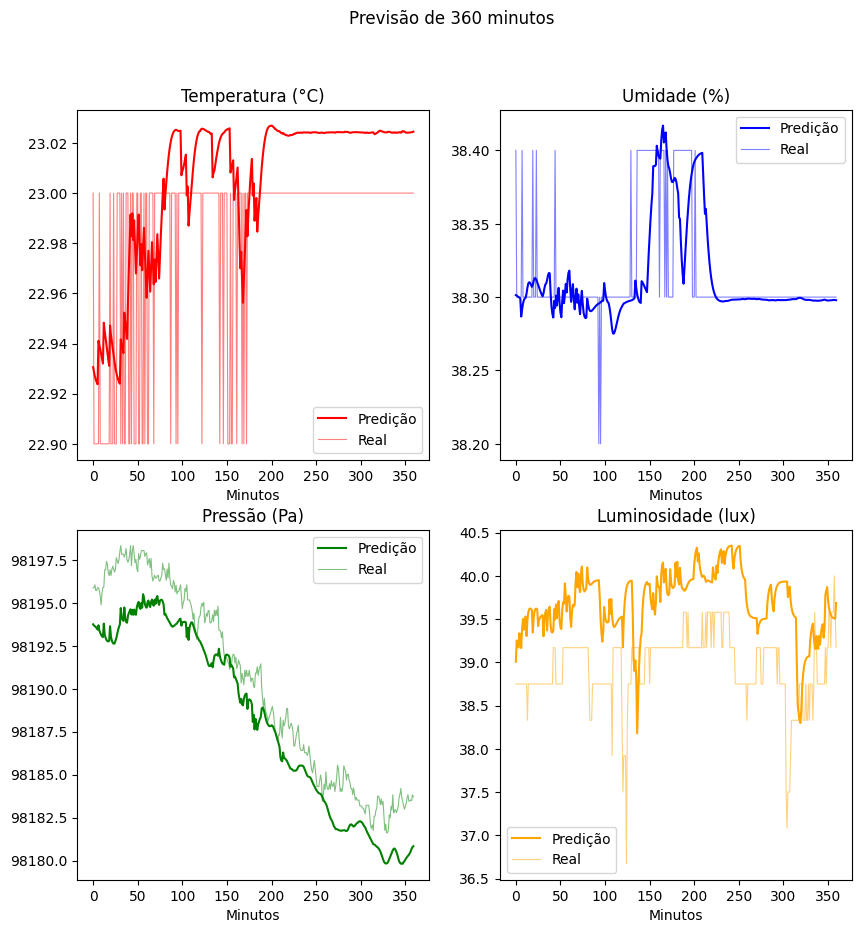

In [7]:
predict_minutes(360)

Para fins de outra validação e como o tamanho do conjunto de teste permite, pode-se predizer todas as próximas 24 horas, obtendo-se novamente previsões minutos a minuto para as medições da sala controlada. Como citado anteriormente, é possível ver que o comprotamento visual dos gráficos, considerando a escala, aproxima muito mais a série prevista da real; ainda, esse comportamento é só visual, pois os MAPEs permanecem na mesma faixa como esperado, com vairações proporcionais quando comparados aos MAPEs do teste anterior.

Com isso, pode-se dizer que para obter previsões a cada minuto a rede faz um bom trabalho mesmo que para um grande volume de horas, obtendo MAPEs consistentemente baixos nos testes e que indicam que um erro considerável possivelmente iria requerir previsões de séries até vários dias a frente; o parâmetro mais suscetível ao erro fica na luminosidade, dado o comportamento já discutido. Enquanto isso, o parâmetro de pressão parece muito consistente para previsões ainda muito mais longas. Temperatura e umidade ficam no meio termo entre estes.

Vale notar que os resultados são bons porém o dataset se trata de dados de uma sala controlada, onde espera-se uim comportamento das séries temporais que possua realmente características que a rede possa aprender bem como sazonalidade mais consistente e a menor razão entre amplitude e magnitude discutidas; com certeza esse é o principal fator dos MAPEs baixos. Como o modelo serve bem para este nicho de situação, isso não necessariamente é um problema.

>>> Erro (MAPE) <<<
Temperatura: 0.146%
Umidade: 0.061%
Pressão: 0.002%
Luminosidade: 2.313%


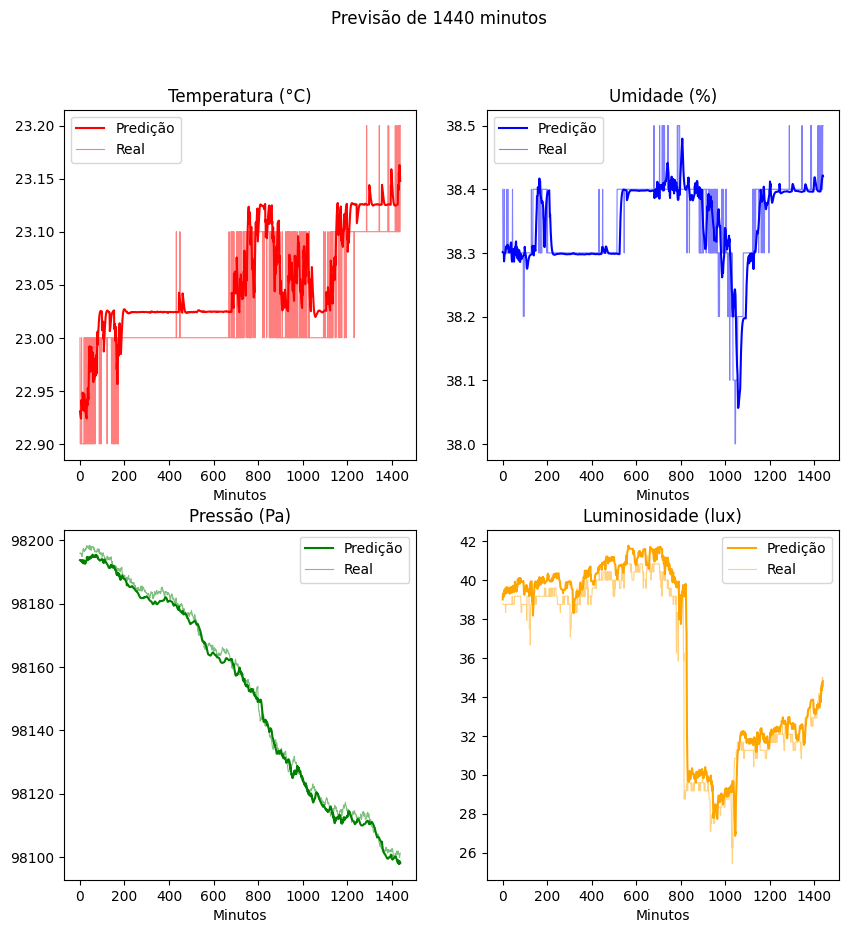

In [8]:
predict_minutes(1440)